# Advanced Usage

This tutorial showcases advanced functionalities and applications of GETTSIM's interface. For an introductory tutorial see [here](basic_usage.ipynb). The introductory tutorial showcases GETTSIM's two main functions using a minimal working example:

1. `set_up_policy_environment` which loads a policy environment for a specified date.

2. `compute_taxes_and_transfers` which allows you to compute taxes and transfers given a specified policy environment for household or individual observations.

This tutorial dives deeper into the GETTSIM interface to acquaintance you with further useful functionalities. Specifically, this tutorial shows how to navigate the numerous [input and target](../crosswalk.rst) variables that the package supports as well as how GETTSIM processes them internally using the example of child benefits in the German taxes and transfers system.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gettsim import set_up_policy_environment
from gettsim import compute_taxes_and_transfers
from gettsim import plot_dag
from gettsim.hypo import gettsim_hypo_data


## Example: Kindergeld (Child Benefits)    
    
For this tutorial, we will focus on *Kindergeld*, which is a child benefit that can be claimed by parents in Germany. *Kindergeld* can be claimed in different ways and eligibility for families to receive it depends on various variables. For instance, *Kindergeld* can be claimed as a monthly payment but also as a tax credit (*Kinderfreibetrag*) which is more advantageous for higher income groups. Additionally, eligibility depends on factors like the age and work status of children. These factors make it a more complex feature of the German taxes and transfers system than one might initially believe.  

In the following, we will inspect in detail how the German *Kindergeld* is implemented in GETTSIM to showcase further functionalities of the package. To start off, we load a policy environment to work with.

In [2]:
policy_params, policy_functions = set_up_policy_environment("2020")

The according policy parameters are saved under the key `kindergeld`.

In [3]:
policy_params["kindergeld"]

{'kindergeld_hoechstalter': 25,
 'kindergeld': {1: 204, 2: 204, 3: 210, 4: 235},
 'kindergeld_einkommensgrenze': 8004,
 'kindergeld_stundengrenze': 20,
 'datum': datetime.date(2020, 1, 1)}

## DAG Plots for Visualization of the Taxes and Transfers System

To get a better picture of how *Kindergeld* is implemented in GETTSIM and, meanwhile, of the structure of the German taxes and transfers system, we can utilize GETTSIM's visualization capabilities which are concentrated in the function `plot_dag`. This function creates a directed acyclic graph (DAG) for the taxes and transfers system. It offers many different visualization possibilities. The [guide on visualizing the taxes and transfers system](../how_to_guides/visualizing_the_system.ipynb) gives an in depth explanation of the function. 

To figure out which variables are relevant for the child benefit, we plot an according slice of the entire taxes and transfers system implemented in GETTSIM using `plot_dag`. The function was already imported with all other relevant packages at the beginning of this tutorial. To select the relevant plot, we have to define selectors that we can pass as arguments to the function. We can check the possible output variables [here](../crosswalk.rst) to find the relevant variable name for our application.

In [4]:
selectors = {"type": "ancestors", "node": "kindergeld_m"}

Since we are interested in the child benefits, we select the node `kindergeld_m` and plot its `ancestors`, which are all the nodes `kindergeld_m` directly or indirectly depends on. As the plot below shows, the variable depends on many other nodes and generates a very large DAG. Clicking on a node links to the according function or variable.

In [6]:
plot_dag(functions=policy_functions, selectors=selectors);

Loading BokehJS ...

An alternative way to inspect the variable is by looking at its neighbors in the DAG. This depiction shows the related variables and functions up to two nodes away from `kindergeld_m`. It reveals `descendants` of `kindergeld_m`: `kindergeld_m_tu` and `kindergeld_m_hh`. These variables contain the child benefits on tax unit and household level respectively.

In [7]:
selectors = {"type": "neighbors", "node": "kindergeld_m", "order": 2}
plot_dag(functions=policy_functions, selectors=selectors);

Loading BokehJS ...

## Computing Variables of Interest

Once we have inspected the DAG, we now have an impression of the various input variables and functions that influence our variable  of interest. As a next step, we will load a set of simulated household data and inspect how we can compute the *Kindergeld* using `compute_taxes_and_transfers` and use the function's features and error messages to aid us in this process.

### Simulated Data

We load a pre-defined simulated data set from a .csv-file. It contains information on households with two adults (age 50) and zero, one, or two children which are either 5 or 10 years old. Each household type occurs with the same frequency in the data. 

The household observations are otherwise identical i.e. the households with children are just replications of the child-free households and for each set of adults with a given income, there are two counterparts, a set of adults with one child and and a set of adults with two children. 

The loaded dataset is sorted accordingly. The first observations only contain child-free individuals while the last observations show the two-child households.

In [ ]:
## idea for use of hypo data (but so far, the hypo data return single-earner families only)
data = pd.DataFrame()
for wage in np.arange(1500,8000,250):
    data=data.append(gesstim_hypo_data(hhtypen=["coup2ch"], alter=50, alter_kind_1=10, alter_kind_2=5, bruttolohn=wage))

In [8]:
data = pd.read_csv("household_data_kindergeld.csv")
data

,p_id,hh_id,tu_id,bruttolohn_m,vermögen_hh,prv_krankenv,alter,hat_kinder,kind,anz_minderj_hh,...,vermiet_eink_m,kapital_eink_m,prv_rente_beitr_m,wohnort_ost,jahr_renteneintr,betreuungskost_m,in_ausbildung,behinderungsgrad,arbeitsstunden_w,alleinerziehend
0,0,0,0,1500.0,0,False,50,False,False,0,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
1,1,0,0,1500.0,0,False,50,False,False,0,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
2,4,1,1,1550.0,0,False,50,False,False,0,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
3,5,1,1,1550.0,0,False,50,False,False,0,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
4,8,2,2,1600.0,0,False,50,False,False,0,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2519,2129,2129,NaN,0,False,5,False,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1175,2520,2130,2130,8000.0,0,False,50,True,False,2,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
1176,2521,2130,2130,8000.0,0,False,50,True,False,2,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
1177,2522,2130,2130,NaN,0,False,10,False,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Adults' monthly gross earnings range between €1,500 and €8,000. It is captured in the variable `bruttolohn_m`. We can use the pandas function [pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.describe.html) to assess the variable in detail.

In [9]:
data.bruttolohn_m.describe()

count     786.000000
mean     4750.000000
std      1891.970967
min      1500.000000
25%      3100.000000
50%      4750.000000
75%      6400.000000
max      8000.000000
Name: bruttolohn_m, dtype: float64

The columns contain all the input variables needed to compute `kindergeld_m`.

In [10]:
data.columns

Index(['p_id', 'hh_id', 'tu_id', 'bruttolohn_m', 'vermögen_hh', 'prv_krankenv',
       'alter', 'hat_kinder', 'kind', 'anz_minderj_hh', 'selbstständig',
       'eink_selbst_m', 'ges_rente_m', 'vermiet_eink_m', 'kapital_eink_m',
       'prv_rente_beitr_m', 'wohnort_ost', 'jahr_renteneintr',
       'betreuungskost_m', 'in_ausbildung', 'behinderungsgrad',
       'arbeitsstunden_w', 'alleinerziehend'],
      dtype='object')

### Using Errors and Warnings

As the DAG and column list above show, a large number of inputs is required to compute child benefits for a family. While the DAG is very useful to understand the structure within GETTSIM behind a variable or function, it might be difficult to infer which inputs exactly are needed in the data to compute a desired output. The function `compute_taxes_and_transfers` thus directly provides multiple mechanisms that help you identify the required input variables to compute certain taxes and transfers.

As shown in the [basic usage tutorial](basic_usage.ipynb), the function requires `data`, one or multiple `targets`, and `policy_params` as well as `policy_functions` to compute taxes and transfers for a given policy environment. 

Since our data set includes all required input columns already, the function does so without problems.

In [11]:
result = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets="kindergeld_m",
    functions=policy_functions,
)
result.head(3)

,kindergeld_m
0,0
1,0
2,0


#### Error Messages: Missing Inputs

However, if we have failed to add a required column, the function throws an error with a message that specifies which columns are missing. For example, the variable `bruttolohn_m` holds information on monthly gross earnings and is required to compute child benefits. Dropping it from the data triggers the error.

In [12]:
incomplete_data = data.drop("bruttolohn_m", axis=1)
result = compute_taxes_and_transfers(
    data=incomplete_data,
    params=policy_params,
    targets="kindergeld_m",
    functions=policy_functions,
)

ValueError: The following data columns are missing.

[
    "bruttolohn_m",
]


Similarly, we can pass an empty pandas.DataFrame to the function to get a list of all the necessary input columns to compute the desired target(s).

In [13]:
result = compute_taxes_and_transfers(
    data=pd.DataFrame(),
    params=policy_params,
    targets="kindergeld_m",
    functions=policy_functions,
)

ValueError: The following data columns are missing.

[
    "bruttolohn_m",
    "wohnort_ost",
    "tu_id",
    "eink_selbst_m",
    "ges_rente_m",
    "hat_kinder",
    "alter",
    "selbstständig",
    "prv_krankenv",
    "behinderungsgrad",
    "alleinerziehend",
    "kind",
    "kapital_eink_m",
    "vermiet_eink_m",
    "arbeitsstunden_w",
    "in_ausbildung",
    "prv_rente_beitr_m",
    "betreuungskost_m",
    "jahr_renteneintr",
]


#### Error Messages and Warnings: Unused Inputs

The function `compute_taxes_and_transfers` also has an option that allows you to check for unused inputs in your data. This functionality is controlled through the argument `check_minimal_specification`. By default, it is set to `ignore`, meaning no check is conduced. However, it can also be set to `warn` to trigger a warning or `raise` and error that includes a message stating the unused inputs.

In [14]:
result = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets="kindergeld_m",
    functions=policy_functions,
    check_minimal_specification="raise",
)

ValueError: The following columns in 'data' are unused.


[
    "hh_id",
    "p_id",
    "vermögen_hh",
    "anz_minderj_hh",
]


### Debug Mode

In addition to errors and warnings `compute_taxes_and_transfers` can also be used in debug mode by setting the argument `debug=True`. In this mode, the function returns all inputs and outputs that can be computed while issuing error messages for the parts where the code fails. It is thus a very useful tool to help you set up your code correctly and detect the sources of problems that might arise in the process. Check out the [troubleshooting tutorial](debugging.ipynb) for more information.

### Computing Child Benefits and Taxes

In this section we will compute the *Kindergeld* for our synthetic households. Since households can also claim a tax credit instead of the child benefit (the *Kinderfreibetrag*), we will also compute the income taxes for each household. By default, GETTSIM chooses the financially more favorable option for each case. The results will thus let us inspect how the policy affects different income levels in our data. 

#### Child Benefit

After ensuring all necessary inputs are defined using the features described above, we can compute the *Kindergeld* for our household `data` given the policy environment specified by `policy_params` and `policy_functions`. We compute the variables `kindergeld_m`, which indicates the *Kindergeld* on individual level, `kindergeld_m_tu`, which computes it on tax unit level, and `kindergeld_m_hh`, which computes it on household level.

In [15]:
kindergeld = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets=["kindergeld_m", "kindergeld_m_tu", "kindergeld_m_hh"],
    functions=policy_functions,
)


We can use the pandas function [pandas.Series.value_counts](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) to assess the results. Computing the value frequencies in the data shows that the function assigns either no *Kindergeld* or €204 to individuals. In the data, the child benefit gets assigned to the child who it accounts for. As the `policy_params` shown above reveal, families receive €204 for the first and second child, €210 for the third, and €235 for every following child. Since the data includes only one- or two-child households, there are only two possible values for *Kindergeld* payments.

In [16]:
kindergeld.kindergeld_m.value_counts(normalize=True).round(2)

0      0.89
204    0.11
Name: kindergeld_m, dtype: float64

We can now look at the household and tax unit level to assess how much child benefits the families receive in total. In this example, the household id (`hh_id`) and tax unit id (`tu_id`) is identical for all households. However, even though the household types are distributed evenly in the data, the computed child benefit claims are not. A disproportionately large amount of tax units receives no child benefit even though there are children in the household. 

This difference stems from the variation in incomes. For higher income families, it is more advantageous to claim the *Kinderfreibetrag* which constitutes a tax credit. As GETTSIM by default always chooses the most beneficial taxes and transfers for households, it thus does not assign child benefits to the families for which the tax credit is more favorable.

In [17]:
kindergeld.kindergeld_m_tu.value_counts(normalize=True).round(2)

0      0.75
408    0.15
204    0.10
Name: kindergeld_m_tu, dtype: float64

In [18]:
kindergeld.kindergeld_m_hh.value_counts(normalize=True).round(2)

0      0.75
408    0.15
204    0.10
Name: kindergeld_m_hh, dtype: float64

#### Income Taxes

As the results above show, GETTSIM only computes the child benefit if it is more beneficial for the family than claiming the tax credit. To compare, we can additionally compute the income taxes for our data set `eink_st_tu`. We also compute the variable `bruttolohn_m_tu`, which gives the monthly gross income per tax unit (in our case, this is the combined income of the two adults in the household). 

In [19]:
income = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets=["eink_st_tu", "bruttolohn_m_tu"],
    functions=policy_functions,
)

Since the gross income and child benefit per tax unit is computed on a monthly level while taxes are computed for the time unit of one year, we multiply the former by 12 and drop unused variables as well as duplicates from our DataFrame. The final DataFrame contains the yearly gross income, income tax, child benefit, and number of children in the household.

In [20]:
# Join results in one DataFrame.
df = kindergeld.join([income, data.anz_minderj_hh]).set_index(data.tu_id)
# Multiply variables by 12 to generate yearly values.
df[["bruttolohn_tu", "kindergeld_tu"]] = df[["bruttolohn_m_tu", "kindergeld_m_tu"]] * 12
# Select variables of interest for further steps.
df = df[
    ["bruttolohn_tu", "eink_st_tu", "kindergeld_tu", "anz_minderj_hh"]
].drop_duplicates()
df.head()

,bruttolohn_tu,eink_st_tu,kindergeld_tu,anz_minderj_hh
tu_id,,,,
0,36000.0,1591.047180,0,0
1,37200.0,1843.015567,0,0
2,38400.0,2108.837502,0,0
3,39600.0,2377.984073,0,0
4,40800.0,2649.746369,0,0


We can plot the results for our different household types. The plots below show how GETTSIM computes *Kindergeld* for our families. At a certain income level (around €80,000-€90,000) the tax credit becomes more favorable and GETTSIM assigns the tax break instead of the child benefit. 

In [21]:
def plot_kindergeld(df):
    """Plot the child benefit and income taxes by household type. """
    plt.figure(figsize=[6, 10])
    for i in 0, 1, 2:
        # Create three subplots for each household type.
        plt.subplot(3, 1, i + 1)
        # Slice df according to household type.
        df_slice = df[df.anz_minderj_hh == i].reset_index().drop_duplicates()
        # Plot income tax against gross income by tax unit.
        plt.plot(df_slice.bruttolohn_tu, df_slice["eink_st_tu"], label="Income tax")
        # Plot child benefit agains gross income by tax unit.
        plt.plot(
            df_slice.bruttolohn_tu,
            df_slice["kindergeld_tu"],
            label="Child benefit",
        )
        # Set title, axis labels, and legend.
        plt.title(f"{i} child(ren)")
        plt.ylabel("€ per year")
        plt.xlabel("Yearly gross income in € (per tax unit)")
        plt.legend()
        plt.tight_layout()

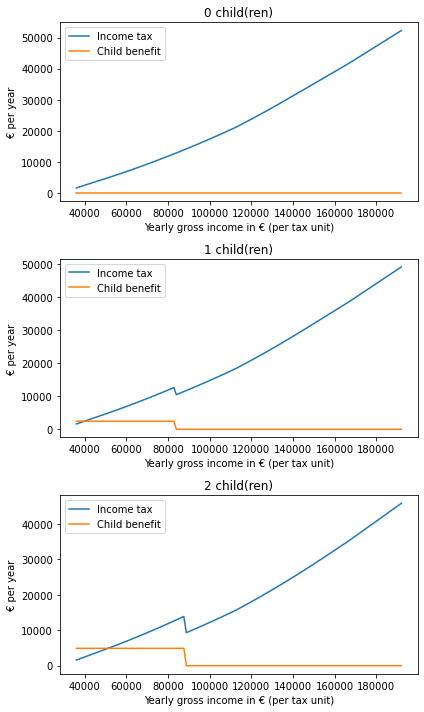

In [22]:
plot_kindergeld(df)

### Columns Overriding Functions

Lastly, it is also possible to substitute internally computed variables using input columns in the data. To override an internal function, it is necessary to specify a column with the same name and pass it to `compute_taxes_and_transfers` using the argument `columns_overriding_functions`.

For instance, for this application we could override the internal function `_kindergeld_m_basis` and set the child benefit to 0. 

In [23]:
new_data = data.copy()
new_data["_kindergeld_m_basis"] = 0

Again, we compute the child benefit and income tax by tax unit. The argument `columns_overriding_functions` also accepts lists of columns to overwrite multiple functions.

In [24]:
outputs = compute_taxes_and_transfers(
    data=new_data,
    params=policy_params,
    targets=["kindergeld_m_tu", "eink_st_tu", "bruttolohn_m_tu"],
    functions=policy_functions,
    columns_overriding_functions="_kindergeld_m_basis",
)

In [25]:
df_new = outputs.join(new_data["anz_minderj_hh"]).set_index(new_data.tu_id)
df_new[["bruttolohn_tu", "kindergeld_tu"]] = (
    df_new[["bruttolohn_m_tu", "kindergeld_m_tu"]] * 12
)
df_new = df_new[
    ["bruttolohn_tu", "eink_st_tu", "kindergeld_tu", "anz_minderj_hh"]
].drop_duplicates()

Since the child benefits are set to zero, GETTSIM computes the tax credit for all households instead. 

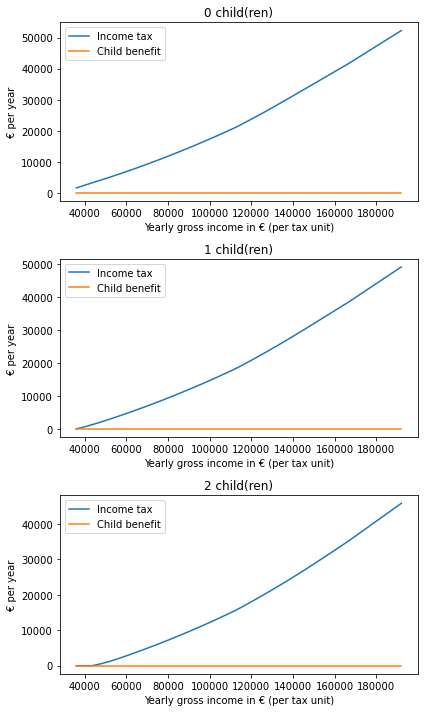

In [26]:
plot_kindergeld(df_new)

Aside from overriding internal function outputs using data columns, it is also possible to substitute the functions entirely. Please refer to the [policy functions tutorial](policy_functions.ipynb) for more information.